In [220]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
from sklearn.cluster import KMeans
import seaborn as sb
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from sklearn.linear_model import LogisticRegression
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.discrete.discrete_model import Logit
from statsmodels.iolib.summary2 import summary_col
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , r2_score
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.discrete.discrete_model import Logit
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTENC
from statsmodels.iolib.summary2 import summary_col
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.discrete.discrete_model import Logit
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTENC
from statsmodels.iolib.summary2 import summary_col

In [221]:
df = pd.read_excel('cylinder4.xlsx')
df.columns

Index(['ï»¿Ã¯Â»Â¿Index', 'Rwf', 'Order_Number', 'BCT1', 'BCT2', 'BCT3', 'BCT4',
       'BCT5', 'BCT_Avg', 'BCT_Spec', 'ECT1', 'ECT2', 'ECT3', 'ECT4', 'ECT5',
       'ECT_Avg', 'SKU', 'Speed_Act', 'Feed_Roll_Gap',
       'Printing_Cylinder_Gap_1', 'Printing_Cylinder_Gap_2',
       'Printing_Cylinder_Gap_3', 'Printing_Cylinder_Gap_4',
       'Number_of_use_Printing_Cylinder', 'Raw_Mat_Strength_Type',
       'Raw_Mat_Strength_Additive', 'Raw_Mat_Combination', 'GL',
       'GLWeigth(Grammage)', 'BM', 'BMWeigth(Grammage)', 'BL',
       'BLWeigth(Grammage)', 'CM', 'CMWeigth(Grammage)', 'CL',
       'CLWeigth(Grammage)', 'Finished_Product_Wid', 'Finished_Product_Leg',
       'Finished_Product_Hig', 'Raw_Mat_Strength_Additive_Percent',
       'New_Printing_Gap_1', 'New_Printing_Gap_2', 'New_Printing_Gap_3',
       'New_Printing_Gap_4', 'New_Average_Printing_Gap'],
      dtype='object')

In [222]:
## rules
df['rules'] = ((df['BCT_Avg'] < df['BCT_Spec']) & ((((df['BCT_Avg'] - df['BCT_Spec'])/df['BCT_Spec'])*100) < 0.03)).astype(int)
df['Finished_Product_Hig'] = (((300<df['Finished_Product_Hig']) & (df['Finished_Product_Hig']<600))).astype(int)
df['Speed_Act_bin'] =(df['Speed_Act']<350).astype(int) 

In [223]:
df.head()

,ï»¿Ã¯Â»Â¿Index,Rwf,Order_Number,BCT1,BCT2,BCT3,BCT4,BCT5,BCT_Avg,BCT_Spec,...,Finished_Product_Leg,Finished_Product_Hig,Raw_Mat_Strength_Additive_Percent,New_Printing_Gap_1,New_Printing_Gap_2,New_Printing_Gap_3,New_Printing_Gap_4,New_Average_Printing_Gap,rules,Speed_Act_bin
0,10,161,3844103801,152.391439,156.115204,154.652131,149.228356,159.891560,154.455738,181.80,...,284,0,15%,1.251346,1.326865,1.557703,2.633172,1.692272,1,1
1,19,98,3909635601,431.447265,429.556860,431.969841,433.558017,435.477450,432.401887,404.30,...,372,0,20%,0.977750,1.746602,2.832975,3.182788,2.185029,0,1
2,24,376,3909957701,302.433254,304.596646,302.290797,305.405366,305.220594,303.989331,287.00,...,335,0,0%,0.688807,3.291399,3.823363,3.995799,2.949842,0,1
3,28,534,3909959801,321.923111,294.067013,311.906002,295.939236,312.781544,307.323381,282.40,...,328,0,15%,1.646364,2.043278,2.468296,2.990545,2.287121,0,1
4,35,115,3909965801,237.860882,245.051614,250.352498,239.646619,244.430691,243.468461,99.17,...,302,0,0%,0.339548,0.895587,1.552640,3.083646,1.467855,0,1


In [224]:
df.columns

Index(['ï»¿Ã¯Â»Â¿Index', 'Rwf', 'Order_Number', 'BCT1', 'BCT2', 'BCT3', 'BCT4',
       'BCT5', 'BCT_Avg', 'BCT_Spec', 'ECT1', 'ECT2', 'ECT3', 'ECT4', 'ECT5',
       'ECT_Avg', 'SKU', 'Speed_Act', 'Feed_Roll_Gap',
       'Printing_Cylinder_Gap_1', 'Printing_Cylinder_Gap_2',
       'Printing_Cylinder_Gap_3', 'Printing_Cylinder_Gap_4',
       'Number_of_use_Printing_Cylinder', 'Raw_Mat_Strength_Type',
       'Raw_Mat_Strength_Additive', 'Raw_Mat_Combination', 'GL',
       'GLWeigth(Grammage)', 'BM', 'BMWeigth(Grammage)', 'BL',
       'BLWeigth(Grammage)', 'CM', 'CMWeigth(Grammage)', 'CL',
       'CLWeigth(Grammage)', 'Finished_Product_Wid', 'Finished_Product_Leg',
       'Finished_Product_Hig', 'Raw_Mat_Strength_Additive_Percent',
       'New_Printing_Gap_1', 'New_Printing_Gap_2', 'New_Printing_Gap_3',
       'New_Printing_Gap_4', 'New_Average_Printing_Gap', 'rules',
       'Speed_Act_bin'],
      dtype='object')

In [225]:
### TO remove all useless columns 
try:
    df.drop('ï»¿Ã¯Â»Â¿Index',inplace= True , axis =1)
    df.drop('Order_Number',inplace= True , axis =1)
    df.drop('Raw_Mat_Combination',inplace= True , axis =1)
    df.drop('GL',inplace=True,axis=1)
    df.drop('CL',inplace=True,axis=1)
    df.drop('New_Printing_Gap_1',inplace=True,axis=1)
    df.drop('New_Printing_Gap_2',inplace=True,axis=1)
    df.drop('New_Printing_Gap_3',inplace=True,axis=1)
    df.drop('New_Printing_Gap_4',inplace=True,axis=1)
    df.drop('New_Average_Printing_Gap',inplace=True,axis=1)
    df.drop('Number_of_use_Printing_Cylinder',inplace=True,axis=1)
    df.drop('Rwf',inplace=True,axis=1)
    df.columns
except:
    print("already deleted")



In [226]:
df['rules'].sum()

np.int64(3192)

In [227]:
## Spliting the data
df_true = df.loc[df['rules']==1].copy()
df_true.head(2)
### total true value is 3192
## split the data of false
df_false = df.loc[df['rules']==0].copy()
df_false.head(2)
df_false['rules'].count
### Total value of flase is 30799 prod rejected 
### Note taking randome value from each
df_false_train = df_false.sample(4000)
df_false_train.head(3)
### merge both the data frame
df_train_1 = [df_true,df_false_train]
df_train = pd.concat(df_train_1)

In [228]:
df_train.describe()
### Droping the column which has - until a solution is found
df_train.columns
### Need to reomve String value else the model will fail  or convert them using any group value
list1 = list(df_train)
for i in list1:
    if df_train[i].dtype == 'object':
        try:
            df_train[i] = df_train[i].astype(float)
        except:
            print(f"unable at columns {i}")
### conver this col to decimal 
df_train['Raw_Mat_Strength_Additive_Percent'] = df_train['Raw_Mat_Strength_Additive_Percent'].apply(lambda x: float(x.replace('%',''))/100 if isinstance(x,str) and '%' in x else x)
df_train['Raw_Mat_Strength_Additive_Percent']
### Dropping additive for now
try:
    df_train.drop('SKU',inplace=True,axis=1)
    df_train.drop('Raw_Mat_Strength_Type',inplace=True,axis=1)
    df_train.drop('Raw_Mat_Strength_Additive',inplace= True, axis=1)
    df_train.drop('BM',inplace=True,axis=1)
    df_train.drop('BL',inplace=True,axis=1)
    df_train.drop('CM',inplace=True,axis=1)
except:
    print("hmm already deleted")
#dummies = pd.get_dummies(df_train[['Raw_Mat_Strength_Additive', 'Raw_Mat_Strength_Type']].astype(str), drop_first=True)


unable at columns SKU
unable at columns Raw_Mat_Strength_Type
unable at columns Raw_Mat_Strength_Additive
unable at columns BM
unable at columns BL
unable at columns CM
unable at columns Raw_Mat_Strength_Additive_Percent


In [229]:
df_train.columns

Index(['BCT1', 'BCT2', 'BCT3', 'BCT4', 'BCT5', 'BCT_Avg', 'BCT_Spec', 'ECT1',
       'ECT2', 'ECT3', 'ECT4', 'ECT5', 'ECT_Avg', 'Speed_Act', 'Feed_Roll_Gap',
       'Printing_Cylinder_Gap_1', 'Printing_Cylinder_Gap_2',
       'Printing_Cylinder_Gap_3', 'Printing_Cylinder_Gap_4',
       'GLWeigth(Grammage)', 'BMWeigth(Grammage)', 'BLWeigth(Grammage)',
       'CMWeigth(Grammage)', 'CLWeigth(Grammage)', 'Finished_Product_Wid',
       'Finished_Product_Leg', 'Finished_Product_Hig',
       'Raw_Mat_Strength_Additive_Percent', 'rules', 'Speed_Act_bin'],
      dtype='object')

In [230]:
"""shuffled_indices = np.random.permutation(len(df_train))
test_size_data = int(len(df_train) * 0.2)
test_indices = shuffled_indices[:test_size_data]
train_indices = shuffled_indices[test_size_data:]
df_train.iloc[train_indices]
df_train.iloc[test_indices]
print(len(train_indices)) #### train value split to 80 %
print(len(test_indices)) ##### test value split to 20%"""

'shuffled_indices = np.random.permutation(len(df_train))\ntest_size_data = int(len(df_train) * 0.2)\ntest_indices = shuffled_indices[:test_size_data]\ntrain_indices = shuffled_indices[test_size_data:]\ndf_train.iloc[train_indices]\ndf_train.iloc[test_indices]\nprint(len(train_indices)) #### train value split to 80 %\nprint(len(test_indices)) ##### test value split to 20%'

In [231]:
df_train.columns

Index(['BCT1', 'BCT2', 'BCT3', 'BCT4', 'BCT5', 'BCT_Avg', 'BCT_Spec', 'ECT1',
       'ECT2', 'ECT3', 'ECT4', 'ECT5', 'ECT_Avg', 'Speed_Act', 'Feed_Roll_Gap',
       'Printing_Cylinder_Gap_1', 'Printing_Cylinder_Gap_2',
       'Printing_Cylinder_Gap_3', 'Printing_Cylinder_Gap_4',
       'GLWeigth(Grammage)', 'BMWeigth(Grammage)', 'BLWeigth(Grammage)',
       'CMWeigth(Grammage)', 'CLWeigth(Grammage)', 'Finished_Product_Wid',
       'Finished_Product_Leg', 'Finished_Product_Hig',
       'Raw_Mat_Strength_Additive_Percent', 'rules', 'Speed_Act_bin'],
      dtype='object')

In [232]:

features = ['BCT1', 'BCT2', 'BCT3', 'BCT4', 'BCT5', 'BCT_Avg', 'BCT_Spec', 'ECT1',
       'ECT2', 'ECT3', 'ECT4', 'ECT5', 'ECT_Avg', 'Speed_Act', 'Feed_Roll_Gap',
       'Printing_Cylinder_Gap_1', 'Printing_Cylinder_Gap_2',
       'Printing_Cylinder_Gap_3', 'Printing_Cylinder_Gap_4',
       'GLWeigth(Grammage)', 'BMWeigth(Grammage)', 'BLWeigth(Grammage)',
       'CMWeigth(Grammage)', 'CLWeigth(Grammage)', 'Finished_Product_Wid',
       'Finished_Product_Leg', 'Finished_Product_Hig',
       'Raw_Mat_Strength_Additive_Percent','Speed_Act_bin']


In [236]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [235]:
X = df_train.drop(columns=['rules'])
Y = df_train['rules']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model on the training data
log_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("ROC-AUC Score:", roc_auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9990732159406858
Confusion Matrix:
 [[1175    1]
 [   1  981]]
ROC-AUC Score: 0.9990656649625226

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1176
           1       1.00      1.00      1.00       982

    accuracy                           1.00      2158
   macro avg       1.00      1.00      1.00      2158
weighted avg       1.00      1.00      1.00      2158



In [239]:
from sklearn.metrics import mean_squared_error, log_loss

In [240]:
y_prob_log = log_reg.predict_proba(X_test)[:, 1]  # We take probabilities for class 1

# Calculate RMSE for logistic regression
rmse_log = np.sqrt(mean_squared_error(y_test, y_prob_log))
print(f"RMSE for Logistic Regression: {rmse_log}")

# Calculate McFadden's pseudo R-squared
# First calculate the log-likelihood of the fitted model
ll_full = -log_loss(y_test, y_prob_log, normalize=False)

# Calculate the log-likelihood of the null model (no features, just the intercept)
y_mean = np.mean(y_test)
ll_null = -log_loss(y_test, np.full_like(y_test, y_mean), normalize=False)

# McFadden's R-squared formula
r_squared_log = 1 - (ll_full / ll_null)
print(f"Pseudo R-squared (McFadden) for Logistic Regression: {r_squared_log}")

RMSE for Logistic Regression: 0.029666389822193818
Pseudo R-squared (McFadden) for Logistic Regression: 0.999745215346069


Mean Squared Error for Linear Regression: 0.07362130656535813
R-squared for Linear Regression: 0.7031154537561859


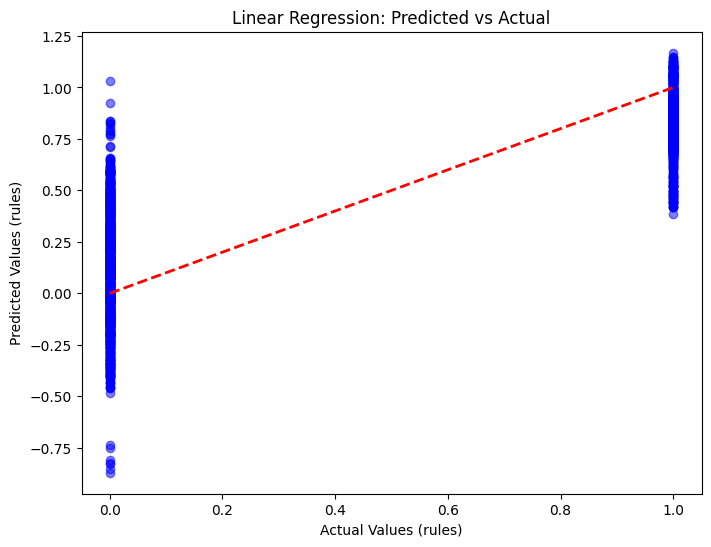

In [238]:
lin_reg = LinearRegression()

# Train the model on the training data
lin_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lin = lin_reg.predict(X_test)

# Calculate evaluation metrics for linear regression
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

# Print evaluation metrics
print(f"Mean Squared Error for Linear Regression: {mse_lin}")
print(f"R-squared for Linear Regression: {r2_lin}")

# Plot predicted vs actual values for linear regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lin, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Linear Regression: Predicted vs Actual')
plt.xlabel('Actual Values (rules)')
plt.ylabel('Predicted Values (rules)')
plt.show()

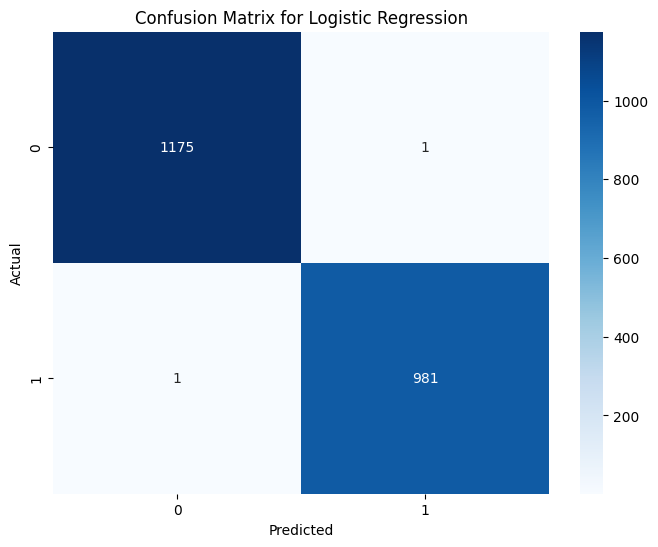

Mean Squared Error for Linear Regression: 0.07362130656535813


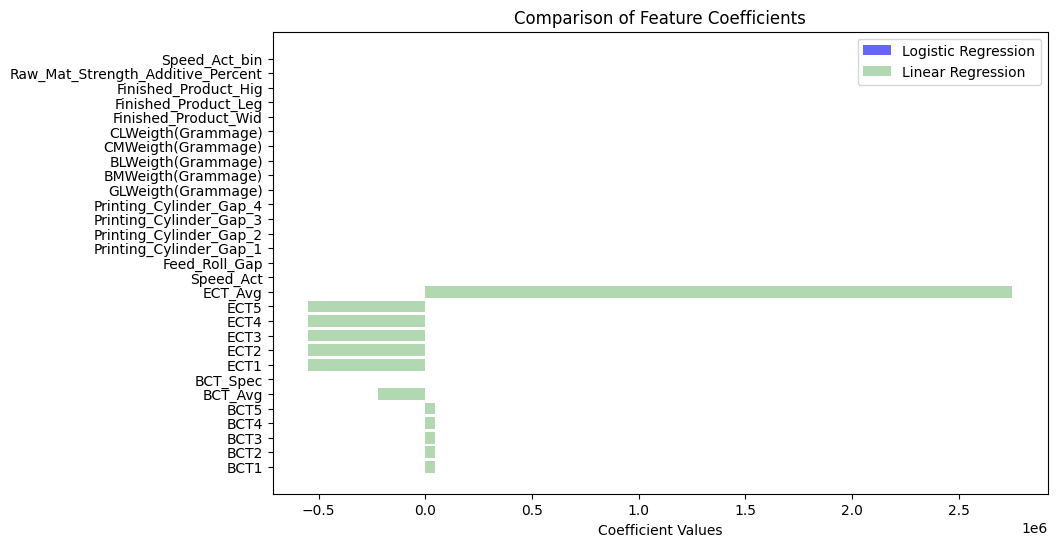

In [237]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix for Logistic Regression")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

# Plot coefficients of logistic regression and linear regression
def plot_coefficients(log_model, lin_model, feature_names):
    plt.figure(figsize=(10,6))

    # Get coefficients
    log_coef = log_model.coef_.flatten()
    lin_coef = lin_model.coef_

    # Plot
    plt.barh(feature_names, log_coef, color='blue', alpha=0.6, label='Logistic Regression')
    plt.barh(feature_names, lin_coef, color='green', alpha=0.3, label='Linear Regression')
    plt.xlabel('Coefficient Values')
    plt.title('Comparison of Feature Coefficients')
    plt.legend()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(conf_matrix)

# Linear Regression for comparison
lin_reg = LinearRegression()

# Train linear regression model
lin_reg.fit(X_train, y_train)

# Predict with linear regression
y_pred_lin = lin_reg.predict(X_test)

# Calculate mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred_lin)
print(f"Mean Squared Error for Linear Regression: {mse}")

# Plot coefficient comparison between Logistic and Linear regression
plot_coefficients(log_reg, lin_reg, X.columns)